# Modeling


## TOC:
* [Preparing data for modeling:](#prep)
    * [Encoding](#encoding)
    * [Outliers & Skewness](#out_skew)
    * [Splitting the data](#splitting)
* [Modeling](#modeling)
    * [Linear Regression](#linear)
    * [Ridge Regression](#ridge)
    * [KNN](#knn)
    * [Ada Boost Regressor](#ada)
    * [SVR](#svr)
    * [Random Forest](#rand_for)
    * [Gradient Boost Regressor](#grad_boost)
* [Cross Validation Comparison](#cv)


In [647]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

data = pd.read_csv('Life_expec_cleaned.csv')

## Encoding<a class="anchor" id="encoding"></a>


Before moving to modeling, we need to do some ecoding-  label "status" variable as numeric column:

In [648]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()


data['class'] = label_encoder.fit_transform(data['status'])

# pd.unique(data['class'])

## Outliers & Skewness<a class="anchor" id="out_skew"></a>

Data is *skewed* when its distribution curve is asymmetrical and **skewness is the measure of the asymmetry**.
Why is it important? Because we want to predict by regression! and regreesion (among other predicting methods) is sensitive for extreme outliers.
 <a href="https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725">For more reading.</a>
 To check for skewness in our data:

In [649]:
data.skew(axis = 0, numeric_only=True)


year                               0.000000
life_expectancy                   -0.638605
adult_mortality                    1.174369
infant_deaths                      9.771044
alcohol                            0.606698
percentage_expenditure             4.643790
hepatitis_b                       -1.997896
measles                            9.425290
under-five deaths                  9.479623
polio                             -2.066216
total_expenditure                  0.561673
diphtheria                        -2.039281
hiv/aids                           5.386623
gdp                                3.352330
thinness_1_19_years                1.713612
thinness_5_9_years                 1.788622
income_composition_of_resources   -1.145458
schooling                         -0.583533
class                             -1.712798
dtype: float64

A good approach for this situation in the **Box-Cox** method.
 This transformation in non-normal approximation for data which is skew in multiple scales (for example schooling skewness is -0.58 and measles skewness is 9.4!).
One restrict for this transformation is that all the data must be not equal to 0 (in our case they are all non-negative).


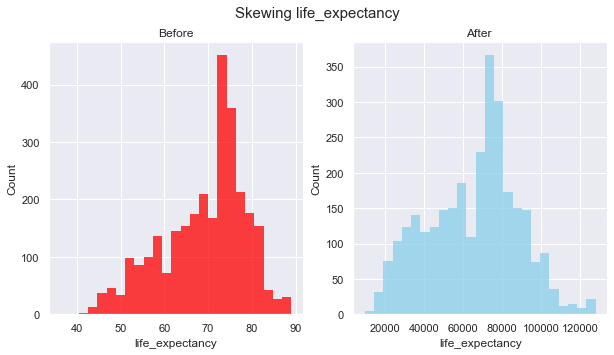

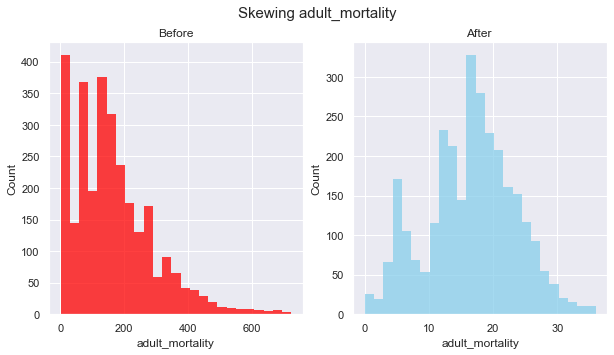

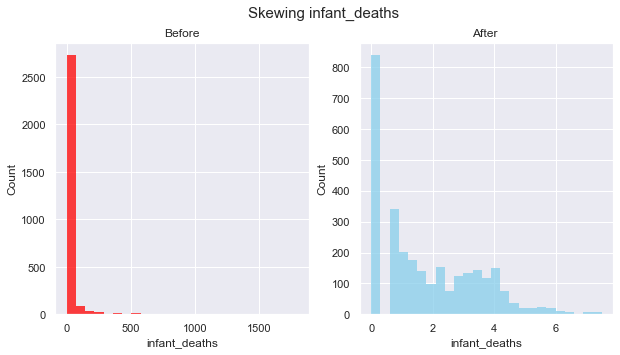

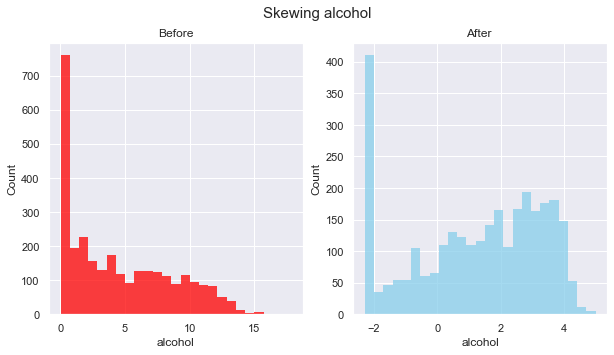

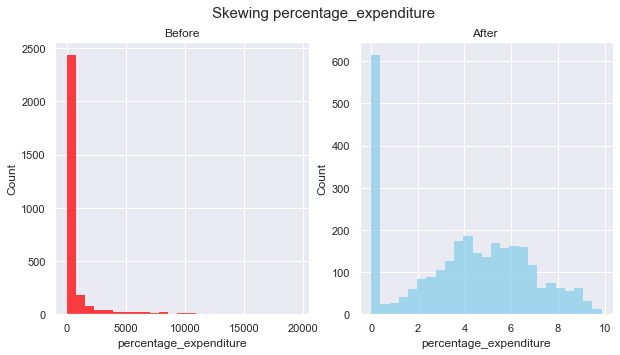

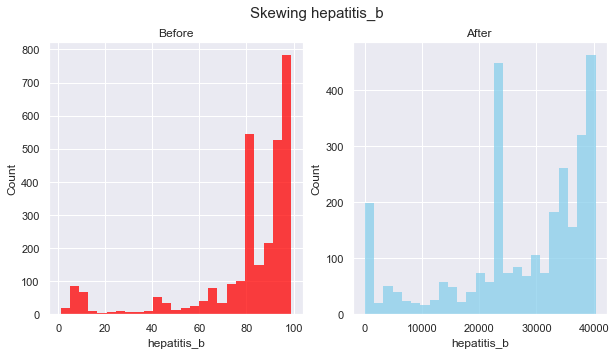

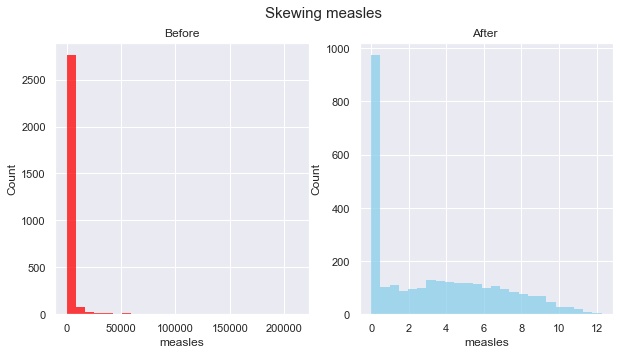

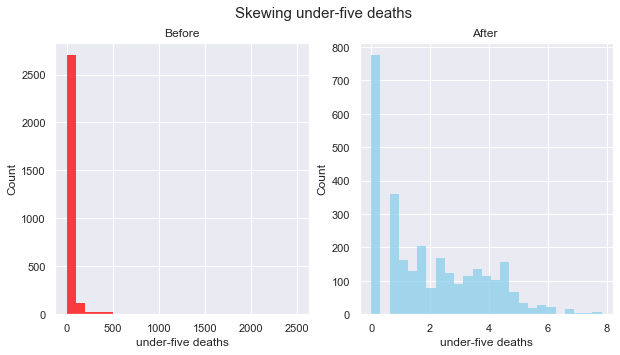

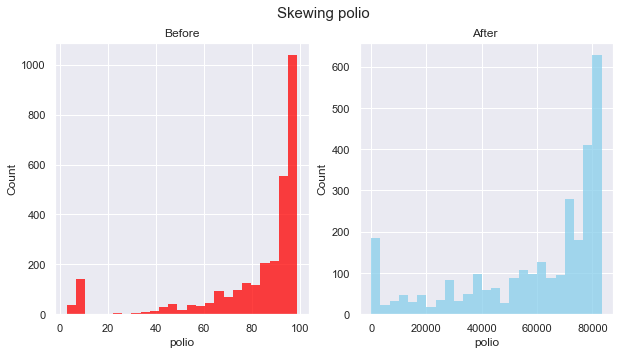

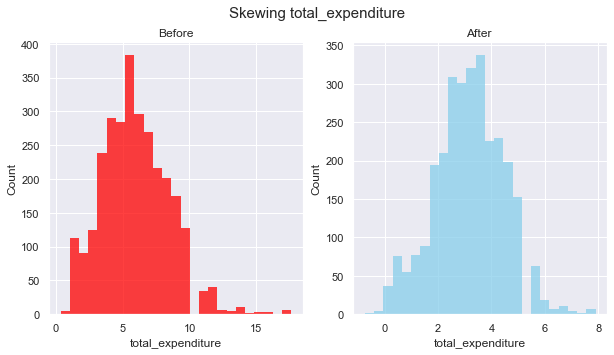

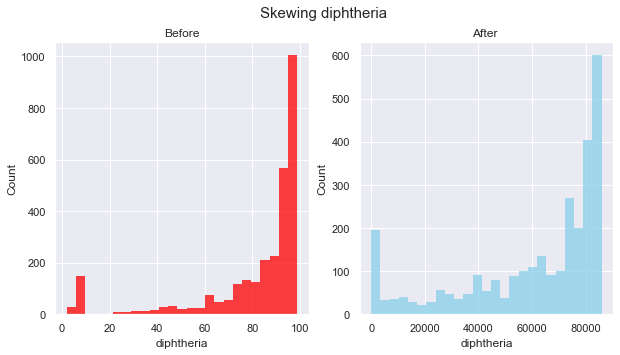

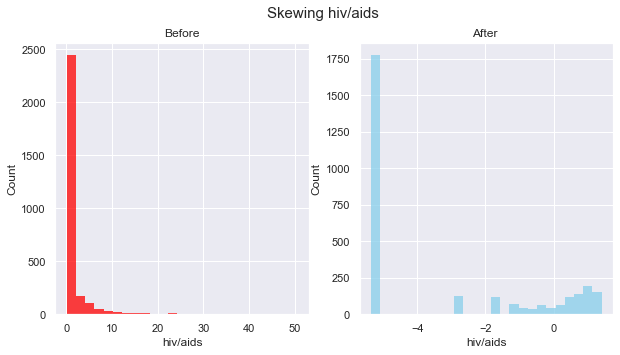

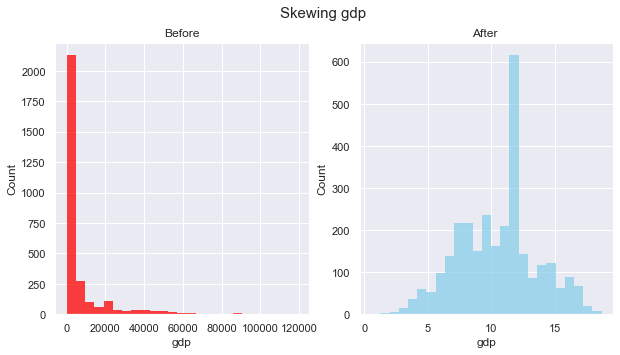

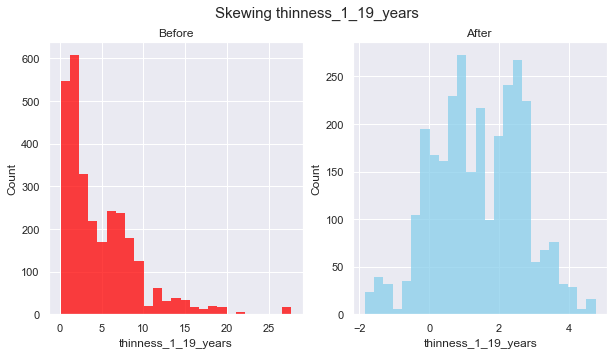

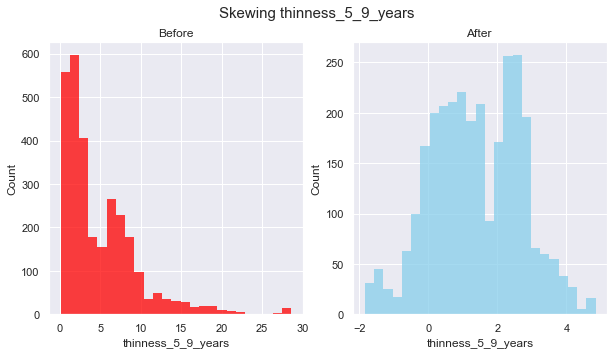

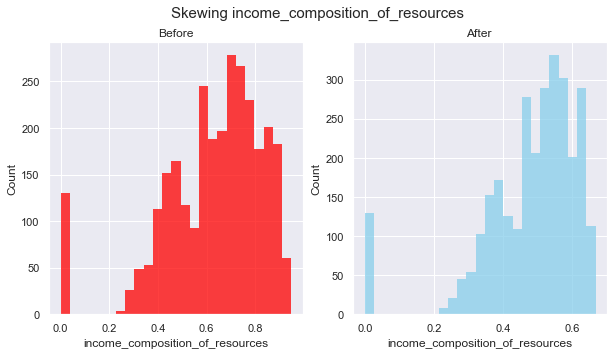

In [650]:
import scipy
import numpy as np

cols_not_to_skew = ['year', 'country', 'status', 'class', 'schooling']
for column in data.columns.drop(cols_not_to_skew):
    figure, axes = plt.subplots(1, 2 , figsize=(10,5))
    figure.suptitle('Skewing {} '.format(column), size = 15)
    axes[0].set_title('Before')
    sns.histplot(ax=axes[0], x=data[column], color="red", linewidth=0, bins=25)

    if data[column].min() > 0 :
        data[column],fitted_lambda= scipy.stats.boxcox(data[column] ,lmbda=None)
    else: # if 0  - applying y = log(x+1) transformation
        data[column] = data[column]+1
        data[column] = np.log(data[column])

    axes[1].set_title('After ')
    sns.histplot(ax=axes[1], x=data[column], color="skyblue", linewidth=0, bins=25)
    plt.show()

Note: After first running, it seems to me that *schooling* is already pretty normaly distributed, so I decided to drop it. Let's do some sanity check:

In [651]:
data.skew(numeric_only=True)

year                               0.000000
life_expectancy                   -0.106877
adult_mortality                   -0.084251
infant_deaths                      0.697864
alcohol                           -0.391462
percentage_expenditure            -0.080296
hepatitis_b                       -0.938540
measles                            0.550742
under-five deaths                  0.643248
polio                             -1.036963
total_expenditure                  0.000371
diphtheria                        -1.051699
hiv/aids                           0.675837
gdp                               -0.014170
thinness_1_19_years               -0.033549
thinness_5_9_years                -0.034442
income_composition_of_resources   -1.658909
schooling                         -0.583533
class                             -1.712798
dtype: float64

Looks Good! :)

## Splitting the data and feature selection <a class="anchor" id="splitting"></a>

Out aim is to predict life expectancy. Let's bring it to be the last column, and object datatype columns (already encoded or deemed useless):


In [652]:
y = data['life_expectancy']
data.drop('life_expectancy', axis = 1, inplace= True)
data = data.join(y)
for col in data.columns:
    if data[col].dtype == 'object' :
        print(col)
        data.drop(col , axis=1, inplace= True)
data.drop('year',axis=1, inplace=True)

country
status


Splitting the data to train and test:

In [653]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.33, random_state = 96)

x_train = train.iloc[:,0:-1].to_numpy()
y_train = train.iloc[:,-1].to_numpy()

x_test = test.iloc[:,0:-1].to_numpy()
y_test = test.iloc[:,-1].to_numpy()

print("Dimension of train set as of now is ", x_train.shape)

Dimension of train set as of now is  (1961, 17)


In [654]:
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

f_test ,_ = f_regression(x_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(x_train, y_train)
mi /= np.max(mi)

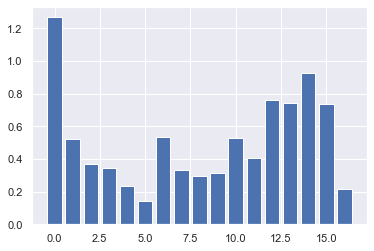

In [655]:
# calculating features weight according to train set and applying it to test set

def select_features_mi(x_train, y_train, x_test):
    features = SelectKBest(score_func= mutual_info_regression , k=15)
    features.fit(x_train, y_train)
    x_train_fs = features.transform(x_train)
    x_test_fs = features.transform(x_test)
    return x_train_fs, x_test_fs , features

x_train_fs, x_test_fs , features_list_mi = select_features_mi(x_train, y_train, x_test)

plt.bar([i for i in range(len(features_list_mi.scores_))], features_list_mi.scores_)
plt.show()

Now let's fit our features according to the last transformation:

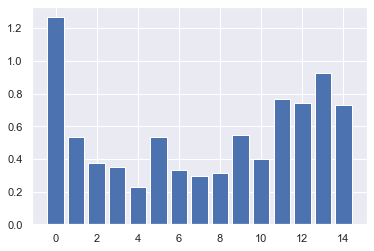

In [656]:

def select_features_f(x_train, y_train, x_test):
    features = SelectKBest(score_func= mutual_info_regression , k=15)
    features.fit(x_train, y_train)
    x_train_fs = features.transform(x_train)
    x_test_fs = features.transform(x_test)
    return x_train_fs, x_test_fs , features

x_train_fs, x_test_fs , features_list_f = select_features_f(x_train_fs, y_train, x_test_fs)

plt.bar([i for i in range(len(features_list_f.scores_))], features_list_f.scores_)
plt.show()

In [657]:
print("Dimension of Train set PRIOR to feature selection ",x_train.shape)
X_train = x_train_fs
X_test = x_test_fs
print("Dimension of Train set AFTER to feature selection ",X_train.shape)

Dimension of Train set PRIOR to feature selection  (1961, 17)
Dimension of Train set AFTER to feature selection  (1961, 15)


# Modeling<a class="anchor" id="modeling"></a>

In [658]:
from sklearn import preprocessing

X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)


In [659]:
# comparison matrices
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import HalvingGridSearchCV

### Linear Regression<a class="anchor" id="linear"></a>

In [660]:
from sklearn.linear_model import LinearRegression
import math
lr = LinearRegression()

# applying to train set
linear_model = lr.fit(X_train,y_train)
# training
y_train_prediction = linear_model.predict(X_train)
y_test_prediction = linear_model.predict(X_test)
print("The TRAIN R^2 score for linear model:", r2_score(y_train, y_train_prediction))
print("The RMSE score for linear model:", math.sqrt(mean_squared_error(y_train_prediction,y_train)))

The TRAIN R^2 score for linear model: 0.8180121475678053
The RMSE score for linear model: 9884.109852851774


So, the *RMSE* value tells us that the **average deviation between the predicted life expectancy made by the model and the actual** is 9884.1.
The R2 value tells us that the **predictor variables in the model are able to explain 81.8% of the variation** in the Life Expectancy.
-NO hyperparameters found.

### Ridge<a class="anchor" id="ridge"></a>

In [661]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

param_grid= {"alpha": [1e0, 0.1, 1e-2, 1e-3], 'tol': [1]}
grid = HalvingGridSearchCV(ridge_model, param_grid,
                           refit= True, verbose=-1, n_jobs=-1, return_train_score=True)
ridge_fit  = grid.fit(X_train, y_train)
# print('MAE: %.3f' % ridge_fit.best_score_)
print('Config: %s' % ridge_fit.best_params_)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 653
max_resources_: 1961
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 653
----------
iter: 1
n_candidates: 2
n_resources: 1959
Config: {'alpha': 1.0, 'tol': 1}


In [662]:
# conducting prediction:
y_train_prediction = ridge_fit.predict(X_train)
y_test_prediction  = ridge_fit.predict(X_test)

print("The training R^2 score for best Ridge Regression model is",r2_score(y_train, y_train_prediction))
print()
print("The training RMSE score for best Ridge Regression model is",math.sqrt(mean_squared_error(y_train_prediction,y_train)))

The training R^2 score for best Ridge Regression model is 0.8179720108258963

The training RMSE score for best Ridge Regression model is 9885.199744538822


### KNN <a class="anchor" id="knn"></a>


In [663]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
param_grid = {'n_neighbors':[1,2,3,4,5,6,7,8,9],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p':[1,2] }
grid = HalvingGridSearchCV(knn, param_grid,
                           refit= True, verbose=-1, n_jobs=-1, return_train_score=True)

knn_fit = grid.fit(X_train , y_train)

print(grid.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 24
max_resources_: 1961
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 144
n_resources: 24
----------
iter: 1
n_candidates: 48
n_resources: 72
----------
iter: 2
n_candidates: 16
n_resources: 216
----------
iter: 3
n_candidates: 6
n_resources: 648
----------
iter: 4
n_candidates: 2
n_resources: 1944
{'algorithm': 'ball_tree', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}


In [664]:
y_train_prediction = knn_fit.predict(X_train)
y_test_prediction  = knn_fit.predict(X_test)

print("The training R^2 score for best KNN model is",r2_score(y_train, y_train_prediction))
print("The training RMSE score for best KNN model is",math.sqrt(mean_squared_error(y_train_prediction,y_train)))

The training R^2 score for best KNN model is 1.0
The training RMSE score for best KNN model is 0.0


### Ada Boost Regressor<a class="anchor" id="ada"></a>

In [665]:
from sklearn.ensemble import AdaBoostRegressor

ada_model = AdaBoostRegressor(learning_rate= 0.2, n_estimators=100)
ada_model_fit = ada_model.fit(X_train, y_train)

y_train_prediction = ada_model_fit.predict(X_train)
y_test_prediction  = ada_model_fit.predict(X_test)

print("The training R^2 score for best AdaBoost model is",r2_score(y_train, y_train_prediction))
print("The training RMSE score for best AdaBoost model is",math.sqrt(mean_squared_error(y_train_prediction,y_train)))


The training R^2 score for best AdaBoost model is 0.8881582716001337
The training RMSE score for best AdaBoost model is 7748.511795832275


### SVR <a class="anchor" id="svr"></a>


In [666]:
from sklearn.svm import SVR

svr = SVR()

param_grid = {'kernel': ['linear','poly', 'rbf', 'sigmoid'],
              'C': [10000,50000,100000,500000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'gamma':['scale', 'auto'] }
grid = HalvingGridSearchCV(svr, param_grid, refit = True, verbose = -1,n_jobs=-1)

svr_fit = grid.fit(X_train, y_train)

print(grid.best_params_)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1961
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 72
----------
iter: 1
n_candidates: 11
n_resources: 216
----------
iter: 2
n_candidates: 4
n_resources: 648
----------
iter: 3
n_candidates: 2
n_resources: 1944
{'C': 100000, 'gamma': 'scale', 'kernel': 'rbf'}


In [667]:
y_train_prediction = svr_fit.predict(X_train)
y_test_prediction  = svr_fit.predict(X_test)

print("The training R^2 score for best SVR model is",r2_score(y_train, y_train_prediction))
print("The training RMSE score for best SVR model is",math.sqrt(mean_squared_error(y_train_prediction,y_train)))

The training R^2 score for best SVR model is 0.9604777397333221
The training RMSE score for best SVR model is 4606.14123596175


### Random Forest Regressor <a class="anchor" id="rand_for"></a>

In [668]:
from sklearn.ensemble import RandomForestRegressor

rFr = RandomForestRegressor()
grid  =  param_grid= {'criterion': ['squared_error', 'absolute_error', 'poisson'],
                      'max_depth': [100, 110],
                      'max_features': [4, 5],
                      'min_samples_leaf': [2, 4],
                      'min_samples_split': [6],
                      'n_estimators': [500,1000] }
grid = HalvingGridSearchCV(rFr, param_grid, refit = True, verbose = -1,n_jobs=-1)
rFr_fit = grid.fit(X_train,y_train)
print(grid.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 72
max_resources_: 1961
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 72
----------
iter: 1
n_candidates: 16
n_resources: 216
----------
iter: 2
n_candidates: 6
n_resources: 648
----------
iter: 3
n_candidates: 2
n_resources: 1944
{'criterion': 'poisson', 'max_depth': 110, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 1000}


In [669]:
y_train_prediction = rFr_fit.predict(X_train)
y_test_prediction  = rFr_fit.predict(X_test)

print("The training R^2 score for best Random Forest model is" ,r2_score(y_train, y_train_prediction))
print("The training RMSE score for best Random Forest model is",math.sqrt(mean_squared_error(y_train_prediction,y_train)))

The training R^2 score for best Random Forest model is 0.9854887223232889
The training RMSE score for best Random Forest model is 2791.060109572611


### Gradient Boost Regressor<a class="anchor" id="grad_boost"></a>

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

param_grid = { 'learning_rate': [8,0.01,0.03],
                'subsample'    : [0.8, 0.5, 0.3],
                'n_estimators' : [500,1000],
                'max_depth'    : [6,8,12,14] }
grid = HalvingGridSearchCV(gbr, param_grid, refit = True, verbose = -1,n_jobs=-1)

gbr_fit = grid.fit(X_train, y_train)
#print(grid.best_params_)

NameError: name 'HalvingGridSearchCV' is not defined

In [671]:
y_train_pred = gbr_fit.predict(X_train)
y_test_pred = gbr_fit.predict(X_test)

print("The training R^2 score for best Gradient Boost model is",r2_score(y_train, y_train_pred))
print("The training RMSE score for best Gradient Boost model is",math.sqrt(mean_squared_error(y_train_pred,y_train)))

ValueError: Input contains NaN.

## Cross Validation Comparison <a class="anchor" id="cv"></a>

First, we want to collect all the models (after fitting with train set) to one place and **compare their R2 on the test data** :

In [59]:
# collecting all models to one data frame

models = []
models.append(('Linear Regression', linear_model))
models.append(('Ridge(Linear) Regression', ridge_fit))
models.append(('K Nearest Neighbour', knn_fit))
models.append(('AdaBoost', ada_model_fit))
models.append(('Support Vector', svr_fit))
models.append(('Random Forest', rFr_fit))
models.append(("Gradient Boost", gbr_fit))

#Appending RMSE and R^2 to each model:

model_name = []
RMSE = []
R2 = []
Y_test_PREDICT = []
for name, model in models:
    model_name.append(name)
    y_test_predict = model.predict(X_test)
    RMSE.append( math.sqrt(mean_squared_error(y_test_predict,y_test)))
    R2.append(r2_score(y_test,y_test_predict))
    Y_test_PREDICT.append(y_test_predict)

models_score = pd.DataFrame(zip(model_name, RMSE, R2), columns=['Name', 'RMSE','R2'])
models_score = models_score.sort_values(by='R2', ascending=False)

fig = plt.figure(figsize =(15, 10))
plt.bar(models_score['Name'], models_score['R2'],color ='skyblue')
plt.title("The R2 score on test data for various models", {'fontsize': 20})
plt.xticks(fontsize=13)
plt.show()

NameError: name 'ridge_fit' is not defined

Ok, So **Gradient Boost** has the higher R2 on our test data.
Now, Let's examine our model preformance on the whole data using K-Fold CV:

In [673]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=0, shuffle=True) # k=10, split the data into 10 equal parts
names = ['Ridge(Linear) Regression','K Nearest Neighbour','AdaBoost','Support Vector', 'Random Forest','Gradient Boost']
# taking final best parameters for each models from its grid:
pred_models = [Ridge(alpha=0.000000001),
               KNeighborsRegressor(n_neighbors=10),
               AdaBoostRegressor(learning_rate=0.2,n_estimators=100),
               SVR(gamma='scale'),
               RandomForestRegressor(n_estimators=100, random_state=42),
               GradientBoostingRegressor(learning_rate= 0.008, max_depth=12, n_estimators=1000, subsample=0.3) ]
R2 = []
CV_std = []
for model in pred_models:
    cross_val_res = cross_val_score(model, X_train, y_train, cv=kfold, scoring ='r2')
    cross_val_res = cross_val_res
    R2.append(cross_val_res.mean())
    CV_std.append(cross_val_res.std())


In [674]:
cv_score = pd.DataFrame(zip(R2,CV_std),columns=['R2', 'Std'],index=names)
cv_score = cv_score.sort_values(by='R2', ascending=False)
cv_score

,R2,Std
Gradient Boost,0.956252,0.007254
Random Forest,0.948814,0.010346
K Nearest Neighbour,0.889138,0.012746
AdaBoost,0.876174,0.011666
Ridge(Linear) Regression,0.814265,0.009404
Support Vector,-0.029282,0.024451


C:\Users\gonne\AppData\Local\Temp\ipykernel_32128\781656566.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


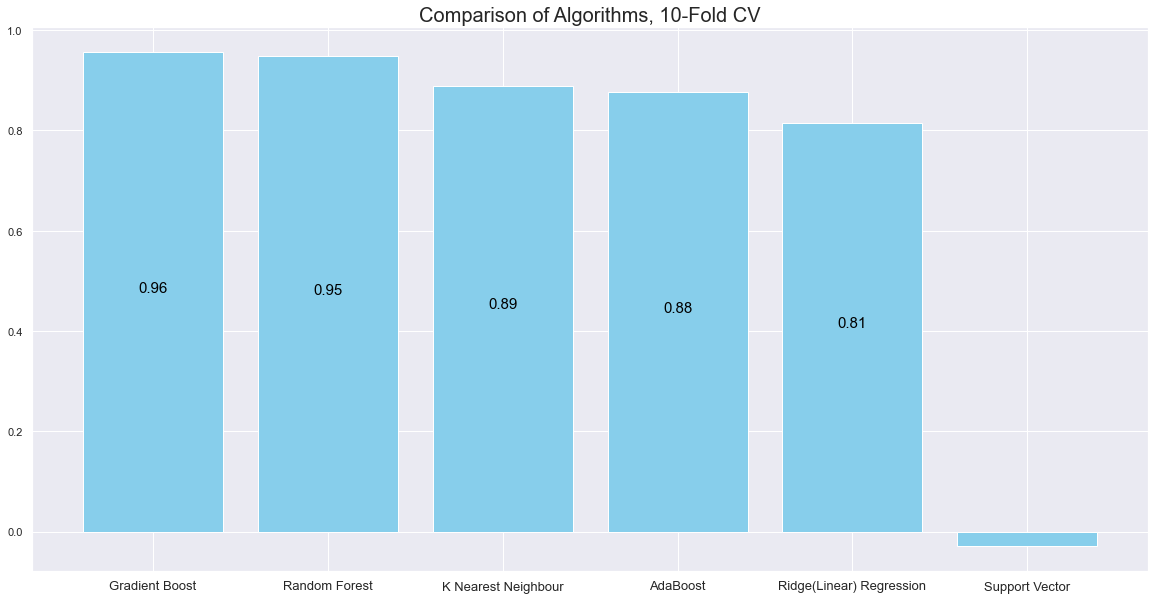

In [675]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)):
        plt.annotate("%.2f" %y_list[i-1],(i-1,y_list[i-1]/2),ha="center", color = 'black', size = 15)


def add_value_label_h(x_list,y_list):
    for i in range(1, len(x_list)):
        plt.annotate("%.2f" %y_list[i-1],(y_list[i-1]/2,x_list[i-1]/2),ha="center", color = 'black', size = 15)

fig, ax = plt.subplots(figsize=(20,10))
plt.title('Comparison of Algorithms, 10-Fold CV',{'fontsize': 20})
plt.bar(cv_score.index,cv_score['R2'], color ='skyblue')
plt.xticks(fontsize=13)
add_value_label(cv_score.index,cv_score['R2'])
fig.show()



**Gradient Boost wins again!**

## Which factor has the mose impact?

Before the modeling we used Multy-Regression to take in count only part of the factors:

C:\Users\gonne\AppData\Local\Temp\ipykernel_18576\1365488983.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


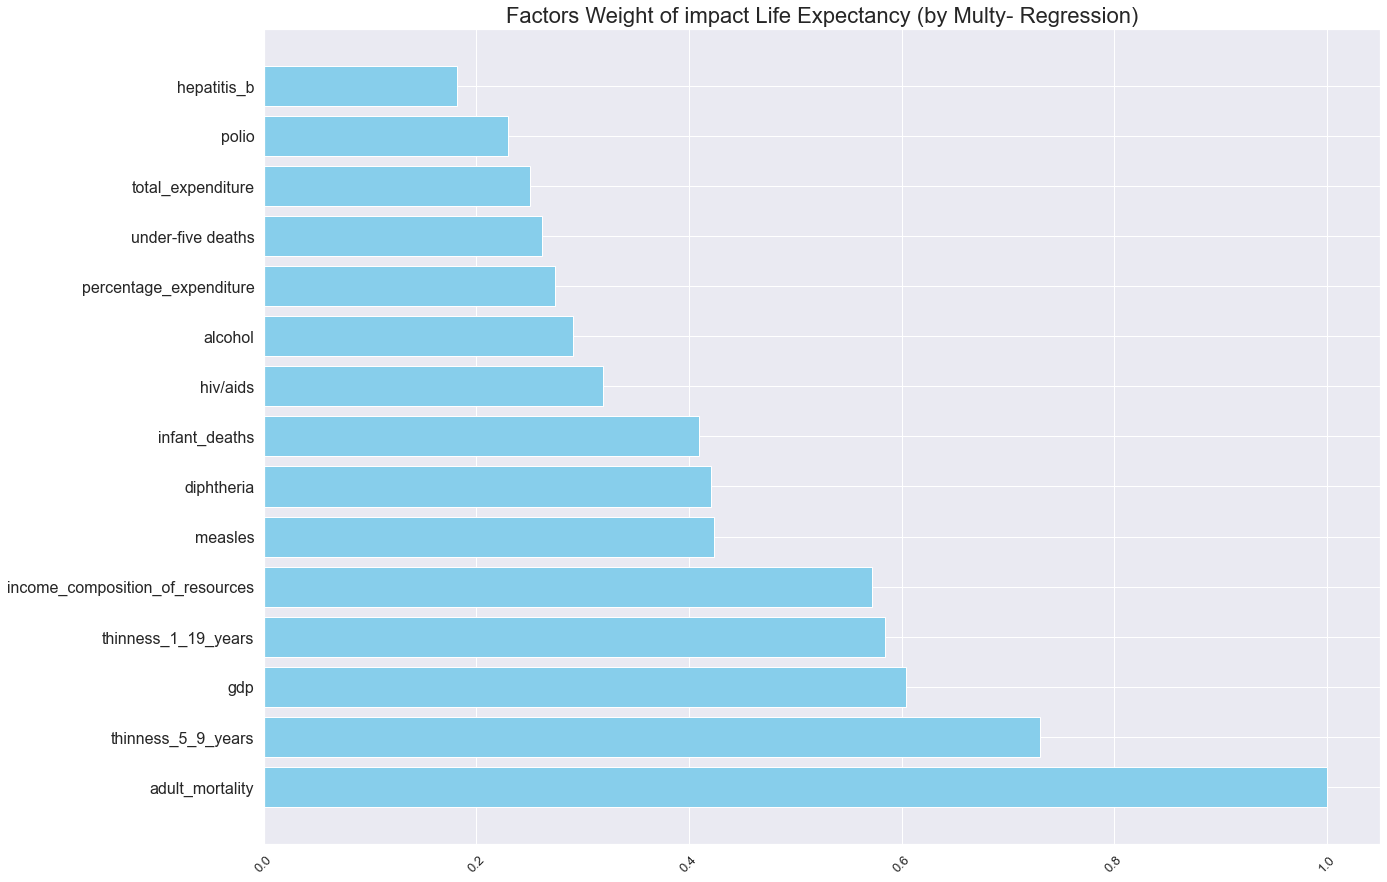

In [60]:
cols = features_list_f.get_support(indices=True)
features_df_new = data.iloc[:,cols]   #data with only the remain cols
remain_cols = features_df_new.columns #names of  the remain cols


weight = pd.DataFrame(features_list_f.scores_,index = remain_cols, columns= ["Weight"])
weight['Weight'] = weight['Weight']/ weight['Weight'].abs().max()
weight = weight.sort_values(by='Weight', ascending=False)


fig = plt.figure(figsize=(20,15))
plt.title('Factors Weight of impact Life Expectancy (by Multy- Regression)',{'fontsize': 22})
plt.barh(weight.index , weight['Weight'], color = 'skyblue')
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=16)
fig.show()

And for Gradient Boost (which revealed as the best model according to both test and CV method):


In [64]:
final_gdr = GradientBoostingRegressor(learning_rate= 0.008, max_depth=12, n_estimators=1000, subsample=0.3)
final_gdr.fit(X_train,y_train)
print("Model Accuracy: %.3f" % final_gdr.score(X_test, y_test))


Model Accuracy: 0.946


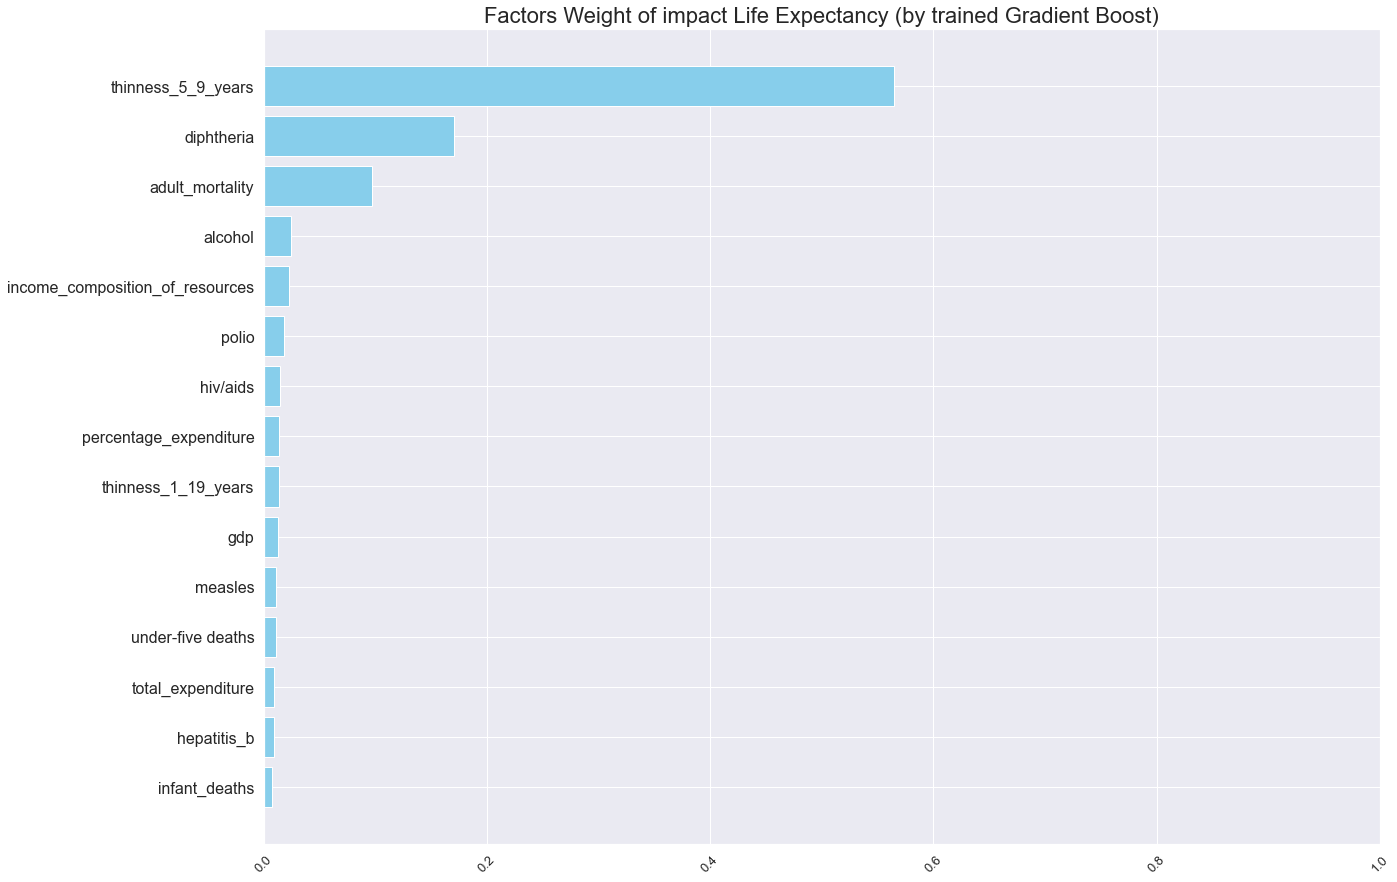

In [65]:
feature_importance = final_gdr.feature_importances_
sorted_importance_results =np.argsort(feature_importance)

fig = plt.figure(figsize=(20,15))
plt.title('Factors Weight of impact Life Expectancy (by trained Gradient Boost)',{'fontsize': 22})
plt.barh(range(len(sorted_importance_results)), feature_importance[sorted_importance_results],
         align='center', color = 'skyblue')
plt.yticks(range(len(sorted_importance_results)), np.array(remain_cols)[sorted_importance_results])
plt.xticks(fontsize=13, rotation=45)
plt.xlim([0, 1])
plt.yticks(fontsize=16)
plt.show()